In [1]:
import numpy as np
import mne
from glob import glob
import pandas as pd
import pylab as plt

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')
from codebase import good_subs, target_dict

In [2]:
import pandas as pd
from mne.time_frequency import psd_array_multitaper
from scipy.stats import ttest_ind
from codebase import get_window_power

import warnings
warnings.filterwarnings("ignore")  # using this for a really dumb deprecation warning, nothing dangerous is happening

res = pd.DataFrame() # for storing our outputs

# Set some params
fs = 500 #saved data is all 500Hz sampling rate
freqs = [3, 8]
start_time = 1.1 # in seconds
win_size = 1.0 # in seconds
subtract_baseline = True
baseline_start = 0; baseline_win = 0.45 # for subtracting off baseline power

for sub in list(good_subs.keys()): #loop through subjects
    for sess in good_subs[sub]:  #loop through stim sites/sessions

        # Load the data
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
        sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')
        elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')
        
        # Get target electrode/coordinates
        target_channel = target_dict[sub][sess][-1]
        target_xyz = np.array(target_dict[sub][sess][0:3])
        
        ## TMS epochs ##
        psd_tms, freqs_used = get_window_power(tms_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)  #output is trials x chans, averaging over frequencies
    
        ## Sham epochs ##
        psd_sham, freqs_used = get_window_power(sham_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)
        
        if subtract_baseline:
            psd_tms_baseline, bs_freqs_used = get_window_power(tms_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            psd_sham_baseline, _ = get_window_power(sham_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            
            psd_tms = psd_tms-psd_tms_baseline
            psd_sham = psd_sham-psd_sham_baseline
        
        # Get TMS vs Sham T-statistic
        t, p = ttest_ind(psd_tms, psd_sham, axis=0, equal_var=False)
        
        # Remove saturated electrodes (thresholding the TEPs)
        from codebase import get_saturated_elecs
        sat_elecs = get_saturated_elecs(tms_dat, samples=250, thresh_=2)
        
        for idx in range(len(t)): #loop through electrodes
            elec_dict = dict(elecs.iloc[idx])  # harvest electrode information
            
            # Flag saturated electrodes
            if idx in sat_elecs:
                sat_flag=True
            else:
                sat_flag=False
                
            # Get Euclidean distance to stim site
            elec_xyz = np.array(elecs.iloc[idx][['anatX', 'anatY', 'anatZ']])
            euc_dist = np.linalg.norm(target_xyz-elec_xyz)
            if euc_dist<77.7:
                distance_category = 'close'
            elif (euc_dist>77.7) & (euc_dist<105.11):
                distance_category = 'middle'
            else:
                distance_category = 'far'
            
            mydict = {'subject': sub, 'session': sess, 'elec_idx': idx, 'T': t[idx], 'pval': p[idx], 
                     'powers_tms': psd_tms[:, idx], 'powers_sham': psd_sham[:, idx], 'saturated': sat_flag,
                     'target_channel': target_channel, 'target_x': target_xyz[0], 'target_y': target_xyz[1], 
                     'target_z': target_xyz[2], 'target_distance': euc_dist, 'distance_category': distance_category}
            mydict.update(elec_dict)
            
            # Update the DataFrame
            res = res.append(mydict, ignore_index=True)
    print(sub)

404
405
416
423
429
430
477
483
518
534
538
559
561


#### Remove possible artifactual responses
Despite this being "cleaned" data, some amplifier saturation does occur

In [3]:
# Simplest method: apply a T-value threshold (only expect this in the positive direction)
# res = res[res['T']<5]

# Alternate method: Measure the TEP for each electrode and set a t-value threshold
# This will do a good job capturing the saturated channels (e.g. sub 559, elec 62; sub 561, elec 195)
res = res[res['saturated']==False]

# Yet another method: Ensure that stimulated electrodes are excluded from analysis

# Remove epileptogenic electrodes
res = res[res['Seizure_Exclude']==0]

# Z-score the target distances for linear modeling
from scipy.stats import zscore
res['target_distance'] = zscore(res['target_distance'])

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 848     Method:             ML        
No. Groups:       13      Scale:              0.6104    
Min. group size:  10      Log-Likelihood:     -1014.3706
Max. group size:  156     Converged:          Yes       
Mean group size:  65.2                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.059     0.091  0.642  0.521  -0.121   0.238
g1 Var      0.135     0.065                              



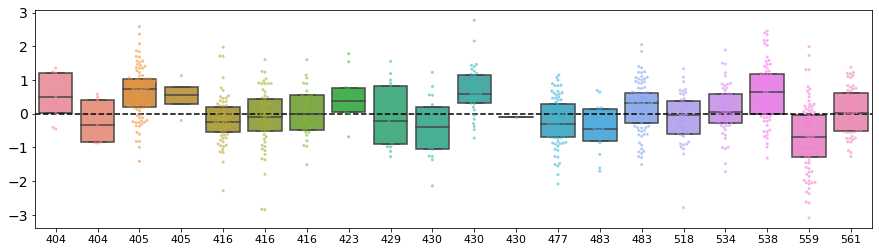

In [12]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset='T')
res_dropna = res_dropna[res_dropna['distance_category'].str.contains('close')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}

model = sm.MixedLM.from_formula("T ~ 1", data=res_dropna, 
                               vc_formula=vcf,
                               groups='subject')

# model = sm.MixedLM.from_formula("T ~ 1 + C(distance_category, Treatment(0))", data=res_dropna, 
#                                 vc_formula=vcf,
#                                 groups='subject')

result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_dropna, key='T')
plt.figure(figsize=(15, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

# Save figure
#plt.savefig('./TMSEEG_plots/LMM_distribution_plot_HFA_0.6_0.9sec.pdf')

**Plot power response by subject-level average**

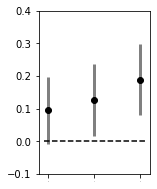

In [5]:
plt.figure(figsize=(2, 3)); ax=plt.subplot(111)

# Average effects per subject (for purposes of plotting)
c_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='close'].groupby('subject').mean()['T'])
m_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='middle'].groupby('subject').mean()['T'])
f_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='far'].groupby('subject').mean()['T'])

from scipy.stats import sem
c_sem = sem(res_dropna[res_dropna['distance_category']=='close'].groupby('subject').mean()['T'])
m_sem = sem(res_dropna[res_dropna['distance_category']=='middle'].groupby('subject').mean()['T'])
f_sem = sem(res_dropna[res_dropna['distance_category']=='far'].groupby('subject').mean()['T'])

# Plot results
plt.errorbar([0, 1, 2], [c_mu, m_mu, f_mu], yerr=[c_sem, m_sem, f_sem], marker='o', elinewidth=3, linewidth=0, ecolor='gray', color='black')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyles='--', color='k')
plt.ylim(-0.1, 0.4)
plt.xticks(fontsize=0);

# Save figure
#plt.savefig('./TMSEEG_plots/distance_terciles_theta_1.1_2.1sec.pdf')

**Power response by session-level average**

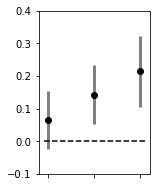

In [6]:
plt.figure(figsize=(2, 3)); ax=plt.subplot(111)

# Average effects per subject (for purposes of plotting)
c_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='close'].groupby(['subject', 'session']).mean()['T'])
m_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='middle'].groupby(['subject', 'session']).mean()['T'])
f_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='far'].groupby(['subject', 'session']).mean()['T'])

from scipy.stats import sem
c_sem = sem(res_dropna[res_dropna['distance_category']=='close'].groupby(['subject', 'session']).mean()['T'])
m_sem = sem(res_dropna[res_dropna['distance_category']=='middle'].groupby(['subject', 'session']).mean()['T'])
f_sem = sem(res_dropna[res_dropna['distance_category']=='far'].groupby(['subject', 'session']).mean()['T'])

# Plot results
plt.errorbar([0, 1, 2], [c_mu, m_mu, f_mu], yerr=[c_sem, m_sem, f_sem], marker='o', elinewidth=3, linewidth=0, ecolor='gray', color='black')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyles='--', color='k')
plt.ylim(-0.1, 0.4)
plt.xticks(fontsize=0);

# Save figure
#plt.savefig('./TMSEEG_plots/distance_terciles_theta_1.1_2.1sec.pdf')

**Plot power response by electrode-level average**

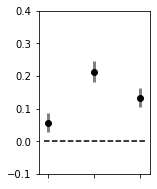

In [7]:
plt.figure(figsize=(2, 3)); ax=plt.subplot(111)

# Average effects per subject (for purposes of plotting)
c_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='close']['T'])
m_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='middle']['T'])
f_mu = np.nanmean(res_dropna[res_dropna['distance_category']=='far']['T'])

from scipy.stats import sem
c_sem = sem(res_dropna[res_dropna['distance_category']=='close']['T'])
m_sem = sem(res_dropna[res_dropna['distance_category']=='middle']['T'])
f_sem = sem(res_dropna[res_dropna['distance_category']=='far']['T'])

# Plot results
plt.errorbar([0, 1, 2], [c_mu, m_mu, f_mu], yerr=[c_sem, m_sem, f_sem], marker='o', elinewidth=3, linewidth=0, ecolor='gray', color='black')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyles='--', color='k')
plt.ylim(-0.1, 0.4)
plt.xticks(fontsize=0);

# Save figure
#plt.savefig('./TMSEEG_plots/distance_terciles_theta_1.1_2.1sec.pdf')